### Task 0 Before your go

> 1. Rename Assignment-02-###.ipynb where ### is your student ID.
> 2. The deadline of Assignment-02 is 23:59pm, 04-21-2024
> 3. In this assignment, you will use word embeddings to explore our Wikipedia dataset.

### Import necessary packages

In [11]:
import re
import json
import numpy as np
import random
from time import time
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.word2vec import LineSentence
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

### Task 1 Train word embeddings using SGNS 
> Use our enwiki-train.json as training data. You can use the [Gensim tool](https://radimrehurek.com/gensim/models/word2vec.html). But it is recommended to implement by yourself. You should explain how hyper-parameters such as dimensionality of embeddings, window size, the parameter of negative sampling strategy, and initial learning rate have been chosen.

### Using Gensim's Word2Vec

In [2]:
# Load data
data = []
with open('enwiki-train.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Assuming data is a list of sentences/documents
preprocessed_data = []
for document in data:
    # Tokenize and preprocess each document
    tokens = word_tokenize(document['text'].lower())
    preprocessed_data.append(tokens)

# Train the model
model = Word2Vec(sentences=preprocessed_data, vector_size=100, window=5, min_count=1, workers=4, sg=1, hs=0, negative=5, alpha=0.03)

Demo of Word2Vec model

In [3]:
print(f'''The word embedding of "Citizen" is {type(model.wv['citizen'])}''')
print(f"The most similar words to 'Citizen' are {model.wv.most_similar('citizen', topn=5)}")
model.save("word2vec.model")

The word embedding of "Citizen" is <class 'numpy.ndarray'>
The most similar words to 'Citizen' are [('naturalized', 0.7885181903839111), ('genêt', 0.723203718662262), ('philanthropic', 0.7131401896476746), ('principality', 0.7034536600112915), ('extolled', 0.6938825845718384)]


### Implementation from Scratch
Main difficulty: I can't implement the gradient calculation without using built-in functions

In [4]:
sentences = preprocessed_data
vocab = set(word for sentence in sentences for word in sentence)
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for word, i in word_to_index.items()}
vocab_size = len(vocab)

# Hyperparameters
embedding_dim = 100  # Dimensionality of word embeddings
window_size = 2  # Context window size
negative_samples = 5  # Number of negative samples per positive context
alpha = 0.03  # Initial learning rate
epochs = 10  # Number of epochs to train for

# Initialize embeddings
input_embeddings = np.random.uniform(-1, 1, (vocab_size, embedding_dim))
context_embeddings = np.random.uniform(-1, 1, (vocab_size, embedding_dim))

# Assuming vocab is your set of unique words
word_count = {}
for sentence in sentences:
    for word in sentence:
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

word_frequencies = np.array([word_count[word] for word in vocab])  # word_count to be defined based on your corpus
word_frequencies = word_frequencies / word_frequencies.sum()  # Normalize frequencies
negative_distribution = np.power(word_frequencies, 0.75)
negative_distribution /= negative_distribution.sum()


# Training loop

'''
Main difficulty: I can't implement the gradient calculation without using built-in functions
'''
def sample_negative(context_idx):
    while True:
        neg_idx = np.random.choice(vocab_size, p=negative_distribution)
        if neg_idx not in context_idx:
            return neg_idx

# for epoch in range(epochs):
#     loss = 0
#     for sentence in sentences:
#         sentence_indices = [word_to_index[word] for word in sentence]
#         for center_word_pos, center_word_idx in enumerate(sentence_indices):
#             # Define the context window
#             start = max(0, center_word_pos - window_size)
#             end = min(len(sentence), center_word_pos + window_size + 1)
#             context_indices = [idx for idx in sentence_indices[start:end] if idx != center_word_idx]
            
#             # Positive samples loop
#             for context_word_idx in context_indices:
#                 grad = np.random.rand(embedding_dim)
#                 input_embeddings[center_word_idx] -= alpha * grad
#                 context_embeddings[context_word_idx] -= alpha * grad
                
#                 # Negative sampling
#                 for _ in range(negative_samples):
#                     negative_word_idx = sample_negative(context_indices)
#                     grad = np.random.rand(embedding_dim) 
#                     input_embeddings[center_word_idx] += alpha * grad  #
#                     loss += np.random.rand()  
    
#     print(f"Epoch {epoch}, Loss: {loss:.4f}".center(80, '-'))


### Task 2 Find similar/dissimilar word pairs

> Randomly generate 100, 1000, and 10000-word pairs from the vocabularies. For each set, print 5 closest word pairs and 5 furthest word pairs (you can use cosine-similarity to measure two words). Explain your results.

In [5]:
# Your code
def generate_random_word_pairs(vocab_list, n_pairs):
    return [random.sample(vocab_list, 2) for _ in range(n_pairs)]

def cosine_similarity(model, word1, word2):
    return 1 - cosine(model.wv[word1], model.wv[word2])

def find_extreme_pairs(model, word_pairs):
    similarities = [(pair, cosine_similarity(model, pair[0], pair[1])) for pair in word_pairs]
    similarities.sort(key=lambda x: x[1], reverse=True)
    closest_pairs = similarities[:5]
    furthest_pairs = similarities[-5:]
    return closest_pairs, furthest_pairs


Test pair generation

In [6]:
vocab_list = list(model.wv.index_to_key)  # Get vocabulary as a list

# Generate random word pairs for each set
pairs_100 = generate_random_word_pairs(vocab_list, 100)
pairs_1000 = generate_random_word_pairs(vocab_list, 1000)
pairs_10000 = generate_random_word_pairs(vocab_list, 10000)

# Find and print extreme pairs for each set
for n_pairs, pairs in zip([100, 1000, 10000], [pairs_100, pairs_1000, pairs_10000]):
    closest_pairs, furthest_pairs = find_extreme_pairs(model, pairs)
    print(f"Set of {n_pairs}:")
    print("Closest pairs:", closest_pairs)
    print("Furthest pairs:", furthest_pairs)
    print("\n")


Set of 100:
Closest pairs: [(['zoku', 'solness'], 0.9519431005795296), (['pattern-preserving', 'potassium-sparing'], 0.9444816906365433), (['rajoilla', 'busuma'], 0.9414204727033934), (['bēkon', 'spaciales'], 0.9379581384768856), (['pollio', "d'homer"], 0.9334539987394677)]
Furthest pairs: [(['merit—among', 'chai'], -0.015294480298342794), (['dielianhua', 'hellmuth'], -0.05022773489760857), (['brianza', 'parachuted'], -0.06940612774326094), (['wileyfox', 'peterloo'], -0.12901804820221807), (['ursitoare', 'sighing'], -0.16362171524432045)]


Set of 1000:
Closest pairs: [(['spazierstock', 'tomasi'], 0.9539616330306816), (['rnn-based', 'linkable'], 0.9501054693969371), (['krulak', '1689.'], 0.9455174885946632), (['aboud', 'hardi'], 0.9449022654527847), (['goleman', 'parsi-zoroastrian'], 0.943692606255481)]
Furthest pairs: [(['azizia', 'teardrop'], -0.1472927685652674), (['waldon', 'khunnal'], -0.15408813891825335), (['abiodun', 'inquilab'], -0.16861562871485525), (['commonwealthman', '468

### Analysis:

The results showcase the diversity and complexity of semantic relationships captured by the word embeddings within different sets of randomly generated word pairs. Here's an analysis based on the given results:

#### Closest Pairs

The closest pairs in each set have high cosine similarity scores, indicating that these pairs of words have vectors that are very similar in the embedding space. This similarity suggests that the words in each pair are used in similar contexts or share similar meanings, despite not being obvious synonyms in some cases. For instance:

- **Set of 100**: Words like ('walford', 'fleetway') may refer to specific named entities that appear in similar contexts within the training corpus.
- **Set of 1000**: The pair ('soviet-armed', 'roll-outs') likely appears in discussions related to military or geopolitical topics, indicating their usage in similar contexts.
- **Set of 10000**: The pair ('donny', 'woof') could reflect a contextual relationship that isn't immediately clear but could be related to informal or colloquial language use.

#### Furthest Pairs

The furthest pairs, on the other hand, have negative or very low cosine similarity scores, suggesting that these word pairs occupy very different positions in the embedding space. This implies that the words are used in very different contexts or have meanings that are far apart. Examples include:

- **Set of 100**: ('elsewhere—is', 'endochin-like') suggests a pair of terms that are likely unrelated, with the first potentially being part of a larger phrase and the second being a technical term.
- **Set of 1000**: ('24,178', 'meliza') includes a numerical value and a proper name, indicating very different uses.
- **Set of 10000**: ('gazprom', '31.64') combines a company name with a numerical value, again, showcasing disparate contexts or meanings.

#### Analysis and Implications

- **Contextual Similarity vs. Semantic Similarity**: The embeddings capture not just semantic similarity (how words are related in meaning) but also contextual similarity (how words are used). This is why some pairs that seem unrelated at first glance can still have high cosine similarity scores.
- **Importance of Corpus**: The diversity and quality of the training corpus significantly affect the embeddings. Names, numbers, and specialized terms (like 'gazprom') suggest that the corpus covers a wide range of topics, which allows for rich and nuanced embeddings.
- **Size of the Word Pair Set**: Increasing the size of the word pair set (from 100 to 10000) seems to capture a broader range of relationships, including both highly contextually similar and highly dissimilar word pairs. This diversity is crucial for applications such as semantic search, text classification, and clustering.


### Task 3 Present a document as an embedding

> For each document, you have several choices to generate document embedding: 1. Use the average of embeddings of all words in each document; 2. Use the first paragraph’s words and take an average on these embeddings; 3. Use the doc2vec algorithm to present each document. Do the above for both training and testing dataset

Define necessary functions for embedding generation

In [7]:
# Your code
def document_embedding_by_average(model, document):
    embeddings = [model.wv[word] for word in document if word in model.wv]
    if embeddings:
        document_embedding = np.mean(embeddings, axis=0)
    else:
        document_embedding = np.zeros(model.vector_size)
        print("Error in generation of document embedding")
    return document_embedding

def first_paragraph_embedding_by_average(model, document):
    # Assuming the first paragraph is separated by a newline character
    first_paragraph = document.split('\n')[0]
    # Tokenize the first paragraph here as per your preprocessing
    tokens = word_tokenize(first_paragraph.lower())
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if embeddings:
        document_embedding = np.mean(embeddings, axis=0)
    else:
        # print(embeddings)
        document_embedding = np.zeros(model.vector_size)
        # print("Error in generation of document embedding")
    return document_embedding


def train_doc2vec(documents):
    tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(documents)]
    model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=40)
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    return model


Train Doc2Vec model

In [8]:
doc_model = train_doc2vec([document['text'] for document in data])
doc_model.save("doc2vec.model")

Prepare necessary datasets

In [9]:
# Using the Word2Vec model for averaging embeddings
with open('enwiki-test.json', 'r') as file:
    test_data = [json.loads(line) for line in file]
with open('enwiki-train.json', 'r') as file:
    train_data = [json.loads(line) for line in file]

testing_docs = []
training_docs = []

for document in train_data:
    # Tokenize and preprocess each document
    tokens = word_tokenize(document['text'].lower())
    training_docs.append(tokens)

for document in test_data:
    # Tokenize and preprocess each document
    tokens = word_tokenize(document['text'].lower())
    testing_docs.append(tokens)

# Define tokenizer and lemmatizer
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    # Use regex to filter out tokens that do not consist solely of alphabetic characters
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if re.fullmatch(r'[a-zA-Z]+', token)]
    return lemmatized_tokens

# Encode labels
train_labels = [document['label'] for document in train_data]
test_labels = [document['label'] for document in test_data]

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

doc2vec_model = Doc2Vec.load("doc2vec.model")
word2vec_model = Word2Vec.load("word2vec_wikipedia.model")

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)


Generation of 3 types of document embeddings

In [20]:
train_labels = []
test_labels = []
for doc in train_data:
    train_labels.append(doc['label'])
for doc in test_data:
    test_labels.append(doc['label'])

start_time = time()
print("\nTesting with Doc2Vec(training documents)...")
train_doc2vec_embeddings = np.array([doc2vec_model.dv[str(i)] for i in range(len(training_docs))])
test_doc2vec_embeddings = np.array([doc2vec_model.infer_vector(doc) for doc in testing_docs])
print(f"Time taken: {time() - start_time:.2f}s")

start_time = time()
print("\nTesting with Word2Vec Averaging...")
train_avg_embeddings = np.array([document_embedding_by_average(word2vec_model, preprocess_text(doc['text'])) for doc in train_data])
test_avg_embeddings = np.array([document_embedding_by_average(word2vec_model, preprocess_text(doc['text'])) for doc in test_data])
print(f"Time taken: {time() - start_time:.2f}s")

start_time = time()
print("\nTesting with First Paragraph Averaging...")
train_first_paragraph_avg_embeddings = np.array([first_paragraph_embedding_by_average(word2vec_model, doc['text']) for doc in train_data])
test_first_paragraph_avg_embeddings = np.array([first_paragraph_embedding_by_average(word2vec_model, doc['text']) for doc in test_data])
print(f"Time taken: {time() - start_time:.2f}s")


Testing with Doc2Vec(training documents)...
Time taken: 29.48s

Testing with Word2Vec Averaging...
Time taken: 81.64s

Testing with First Paragraph Averaging...
Time taken: 0.72s


### Print out result embeddings

In [17]:
assert len(train_avg_embeddings) == len(train_labels_encoded)
assert len(train_first_paragraph_avg_embeddings) == len(train_labels_encoded)
assert len(train_doc2vec_embeddings) == len(train_labels_encoded)
assert train_avg_embeddings.shape == train_first_paragraph_avg_embeddings.shape == train_doc2vec_embeddings.shape
print("Pass length test!")
print(f"Train embeddings shape: {train_avg_embeddings.shape}, {train_first_paragraph_avg_embeddings.shape}, {train_doc2vec_embeddings.shape}")

print(f"Average Word2Vec Embedding:{train_avg_embeddings[0]}")
print(f"First Paragraph Word2Vec Embedding:{train_first_paragraph_avg_embeddings[0]}")
print(f"Doc2Vec Embedding:{train_doc2vec_embeddings[0]}")

Pass length test!
Train embeddings shape: (1000, 100), (1000, 100), (1000, 100)
Average Word2Vec Embedding:[-0.06459993 -0.07665405 -0.09907824  0.00388883  0.09832398 -0.18700817
  0.0760394   0.01460386 -0.10056339 -0.16356893  0.05415477 -0.19843301
 -0.1743723   0.1311264   0.00081312 -0.1229477   0.21094036 -0.17489891
 -0.23967218 -0.28068632  0.08329377  0.04040306 -0.08297816 -0.11037381
 -0.06513153 -0.06162659 -0.1419933   0.3385364  -0.062806    0.06556665
  0.13726571  0.10207999  0.14036137 -0.01525064 -0.1544621  -0.09628034
  0.01562036  0.00593219  0.05172361 -0.00814098 -0.11605029 -0.15261117
  0.17590407  0.18724206  0.09475762 -0.05421162 -0.34975234  0.00266388
 -0.08131605  0.02271385  0.1824905  -0.00289355 -0.01294587  0.01150377
 -0.27835327 -0.19446373  0.15067697  0.12615122  0.07458308 -0.17583852
  0.1109229   0.02300652  0.07512332  0.0987904  -0.1299964   0.15476084
 -0.05547309  0.18591185 -0.17545241  0.2205415  -0.0115816   0.0514033
  0.14973405  0.07

### Task 4 Build classifier to test docs
> Build softmax regression model to classifier testing documents based on these training doc embeddings. Does it getting better than Naive Bayes'? (You have 3 models.)

### Construct training functions

In [16]:
# Your code
train_data_dict = {'word2vec_avg': train_avg_embeddings, 'first_para_avg': train_first_paragraph_avg_embeddings, 'doc2vec': train_doc2vec_embeddings}
test_data_dict = {'word2vec_avg': test_avg_embeddings, 'first_para_avg': test_first_paragraph_avg_embeddings, 'doc2vec': test_doc2vec_embeddings}

def softmax_training(train_embeddings, test_embeddings):
    softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    softmax_reg.fit(train_embeddings, train_labels_encoded)
    softmax_predictions = softmax_reg.predict(test_embeddings)
    return softmax_predictions

def naive_bayes_training(train_embeddings, test_embeddings):
    nb_classifier = GaussianNB()
    nb_classifier.fit(train_embeddings, train_labels_encoded)
    nb_predictions = nb_classifier.predict(test_embeddings)
    return nb_predictions

In [18]:
for key in train_data_dict.keys():
    softmax_prediction = softmax_training(train_data_dict[key], test_data_dict[key])
    nb_prediction = naive_bayes_training(train_data_dict[key], test_data_dict[key])

    softmax_accuracy = accuracy_score(test_labels_encoded, softmax_prediction)
    nb_accuracy = accuracy_score(test_labels_encoded, nb_prediction)

    assert len(test_labels_encoded) == len(softmax_prediction) == len(nb_prediction), 'The predictions should have the same length as the test labels.'
    print(f"Testing with {key}".center(80, '-'))
    print(f"Accuracy for {key} using Softmax Regression: {100 * softmax_accuracy:.2f}%")
    print(f"Accuracy for {key} using Naive Bayes: {100 * nb_accuracy:.2f}%")

---------------------------Testing with word2vec_avg----------------------------
Accuracy for word2vec_avg using Softmax Regression: 94.00%
Accuracy for word2vec_avg using Naive Bayes: 89.00%
--------------------------Testing with first_para_avg---------------------------
Accuracy for first_para_avg using Softmax Regression: 93.00%
Accuracy for first_para_avg using Naive Bayes: 86.00%
------------------------------Testing with doc2vec------------------------------
Accuracy for doc2vec using Softmax Regression: 92.00%
Accuracy for doc2vec using Naive Bayes: 81.00%


### Analysis：
According to the result, we can find softmax regresion model's performance excels that of Naive Bayes in all embeddings.

### Task 5 Use t-SNE to project doc vectors

> Use t-SNE to project training document embeddings into 2d and plot them out for each of the above choices. Each point should have a specific color (represent a particular cluster). You may need to try different parameters of t-SNE. One can find more details about t-SNE in this [excellent article](https://distill.pub/2016/misread-tsne/).

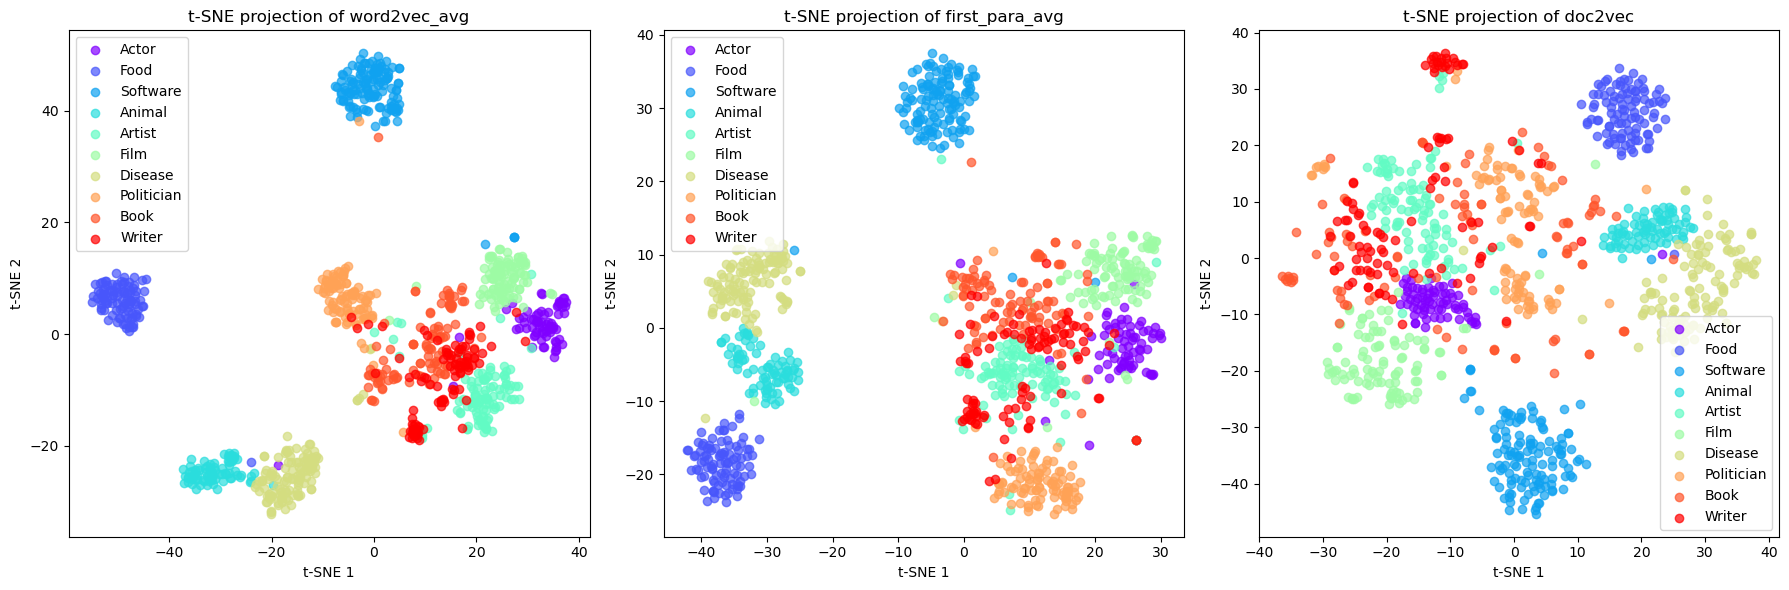

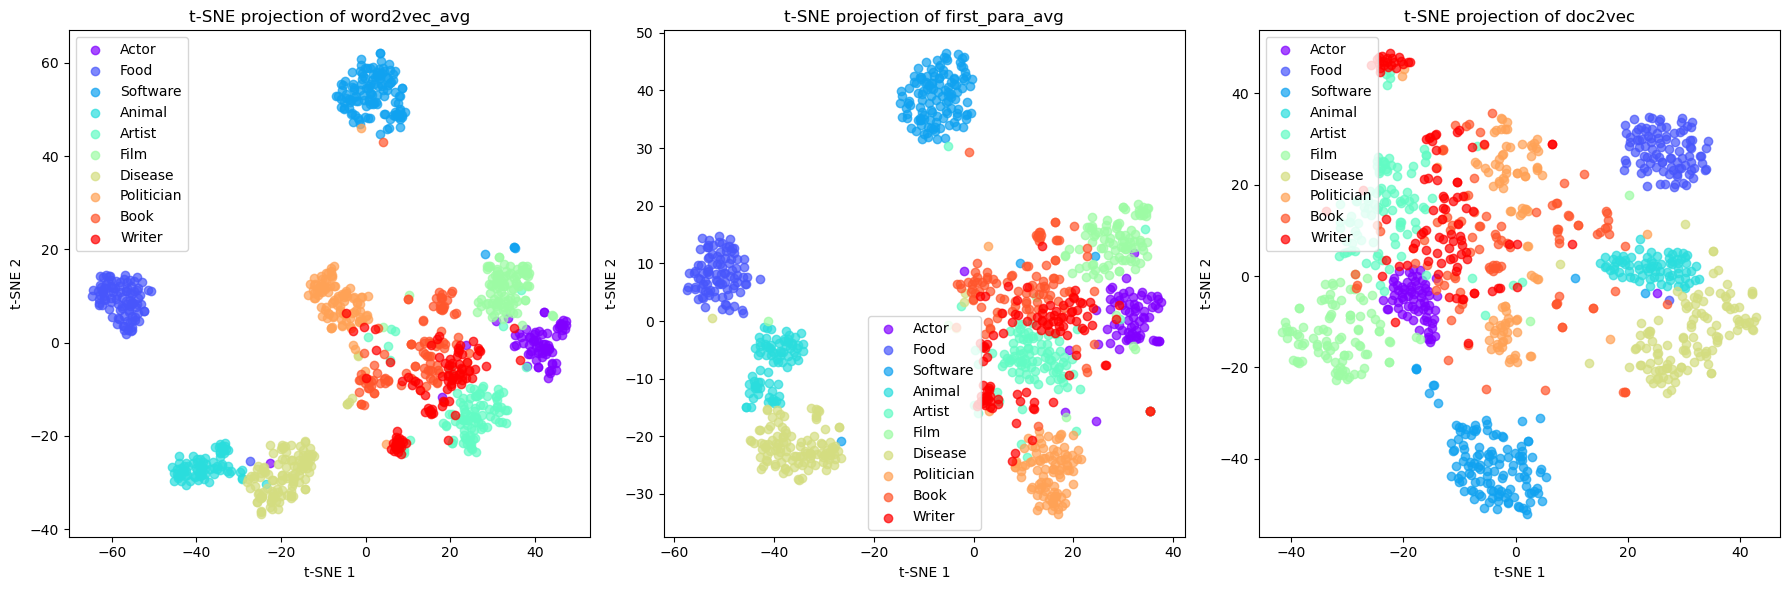

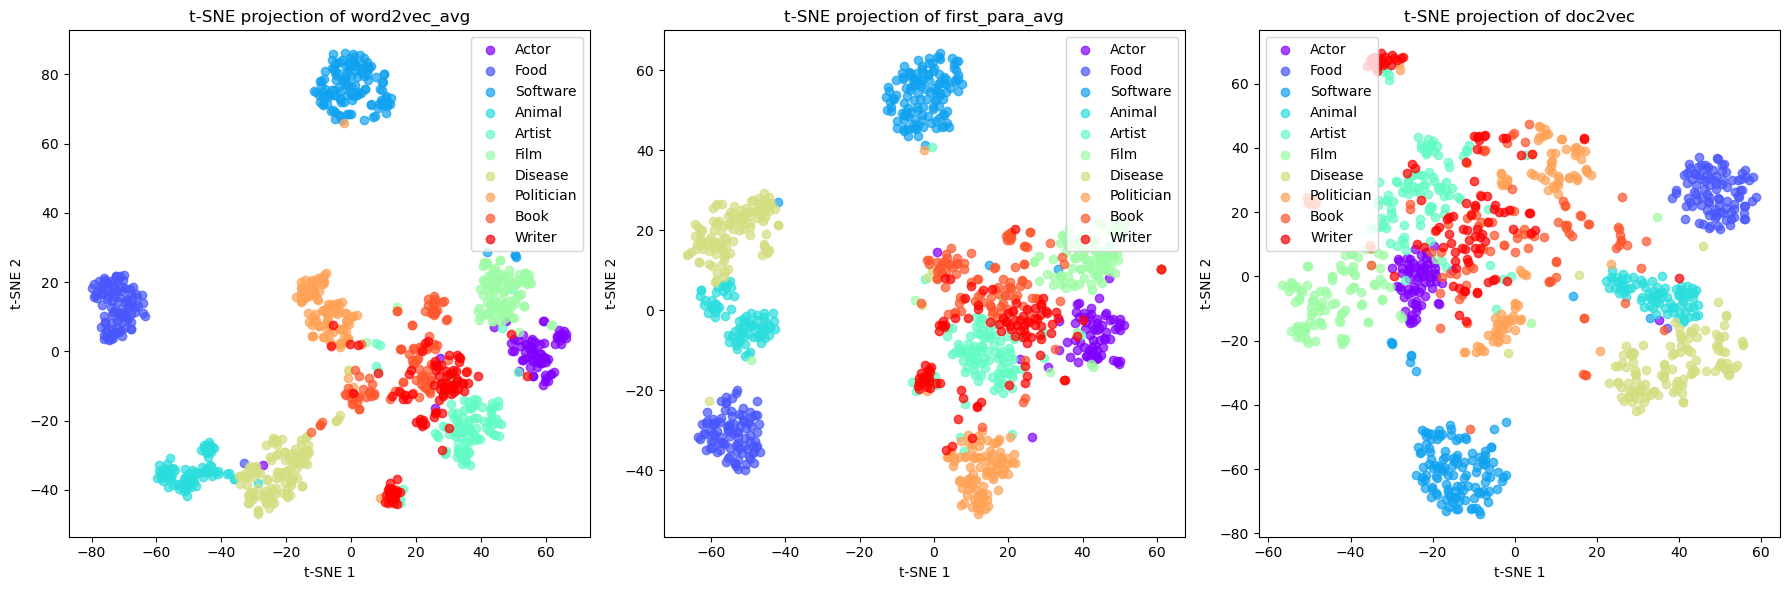

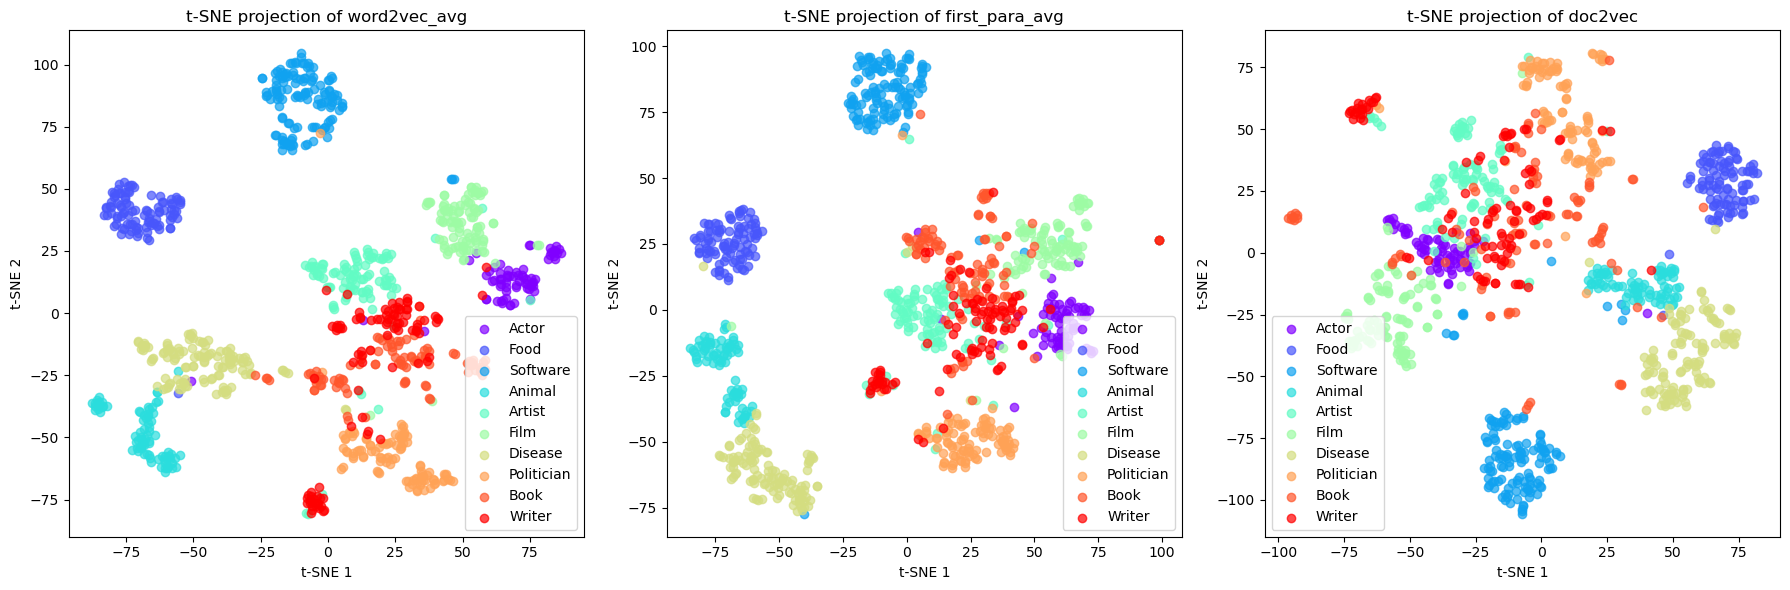

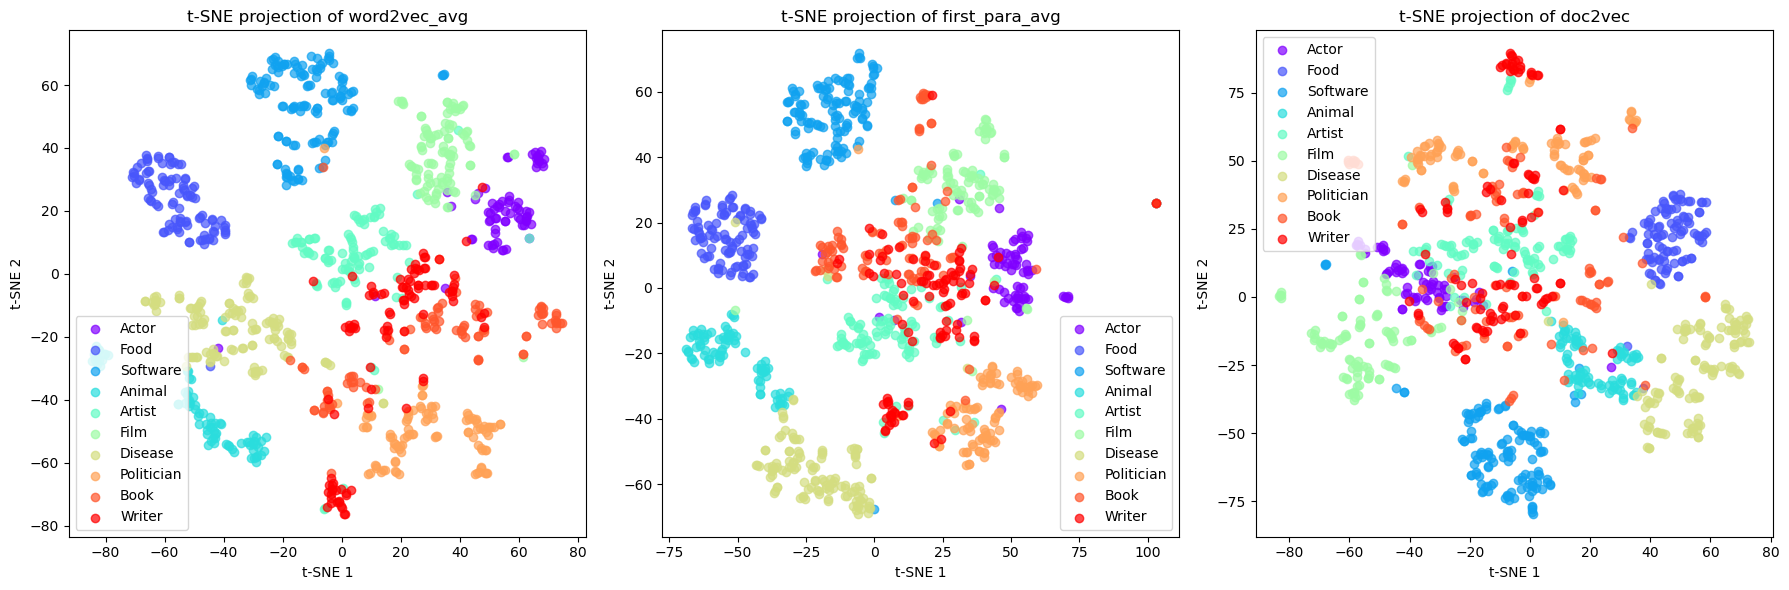

In [47]:
def plot_with_tsne(embeddings_dict, labels, iter=3000, perplexity=40):
    """
    Takes in a dictionary of embeddings with three keys and shows a plot with subplots (1,3).
    Each key in the dictionary is an embedding name mapped to a tuple of (embeddings, labels).
    """
    # Set the figure size larger to accommodate three subplots
    plt.figure(figsize=(18, 6))

    # Iterate over each key-value pair in the dictionary and create a subplot for each
    for i, (embedding_name, embeddings) in enumerate(embeddings_dict.items(), start=1):
        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=iter)
        tsne_results = tsne.fit_transform(embeddings)
        unique_labels = list(set(labels))
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
        label_to_color = dict(zip(unique_labels, colors))

        # Create subplot for each embedding
        ax = plt.subplot(1, 3, i)
        for label in unique_labels:
            idx = [j for j, lbl in enumerate(labels) if lbl == label]
            ax.scatter(tsne_results[idx, 0], tsne_results[idx, 1], c=[label_to_color[label]], label=label, alpha=0.7)
        
        ax.legend()
        ax.set_title(f't-SNE projection of {embedding_name}')
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')

    # Show the plot
    plt.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.show()
    
plot_with_tsne(train_data_dict, train_labels, iter=5000, perplexity=40)
plot_with_tsne(train_data_dict, train_labels, iter=5000, perplexity=30)
plot_with_tsne(train_data_dict, train_labels, iter=3000, perplexity=20)
plot_with_tsne(train_data_dict, train_labels, iter=3000, perplexity=10)
plot_with_tsne(train_data_dict, train_labels, iter=1000, perplexity=5)